In [ ]:
!pip install pytorchcv
!pip install gdown
!gdown --id '1HQRkshrkTfXufzDeeGov_y6vii4Yd52N' -O data.zip
!unzip ./data.zip
!rm ./data.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 32.8 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HQRkshrkTfXufzDeeGov_y6vii4Yd52N
To: /content/data.zip
100% 572k/572k [00:00<00:00, 149MB/s]
Archive:  ./data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cat/
  inflating: __MACOSX/data/._cat     
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/dog/
  inflating: __MACOSX/data/._dog     
   creating: data/truck/
  inflating: __MACOSX/data/._truck   
   creating: data/bird/
  inflating: __MACOSX/data/._bird    
   creating: data/airplane/
  inflating: __MACOSX/data/._airplane

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pytorchcv.model_provider import get_model as ptcv_get_model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
batch_size = 8
cifar_10_mean = (0.491, 0.482, 0.447)
cifar_10_std = (0.202, 0.199, 0.201)
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)
epsilon = 8/255/std
alpha = 0.8/255/std
num_iter = 20
root = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])


In [ ]:
class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform

    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label

    def __getname__(self):
        return self.names

    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'Number of images = {len(adv_set)}')


def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            yp = model(x)
            loss = loss_fn(yp, y)
            train_acc += (yp.argmax(dim=1) == y).sum().item()
            train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

In [ ]:
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    outputs = model(x_adv)
    loss = loss_fn(outputs, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()

    x_adv = torch.clamp(x_adv, (0 - mean)/std, (1 - mean)/std)
    return x_adv


In [ ]:
# IFGSM Attack
def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter):
    x_adv = x.detach().clone()
    x_adv = x_adv.requires_grad_(True)

    for _ in range(num_iter):
        outputs = model(x_adv)
        loss = loss_fn(outputs, y)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            x_adv += alpha * x_adv.grad.sign()
            eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
            x_adv = torch.clamp(x + eta, (0 - mean)/std, (1 - mean)/std).detach_()
            x_adv.requires_grad = True
    return x_adv

Using device: cuda
Number of images = 200
Successfully loaded resnet20_cifar10
Successfully loaded resnet56_cifar10
Error loading densenet121_cifar10: Unsupported model: densenet121_cifar10
Primary model (resnet110_cifar10) loaded successfully.
Benign Accuracy = 0.95000, Benign Loss = 0.22678
FGSM Attack -> Accuracy: 0.59000, Loss: 2.50208
IFGSM Attack -> Accuracy: 0.01000, Loss: 17.31777
Ensemble IFGSM Attack -> Accuracy: 0.00000, Loss: 18.27266
Compressed fgsm to fgsm.tgz
Compressed ifgsm to ifgsm.tgz
Compressed ensemble_ifgsm to ensemble_ifgsm.tgz


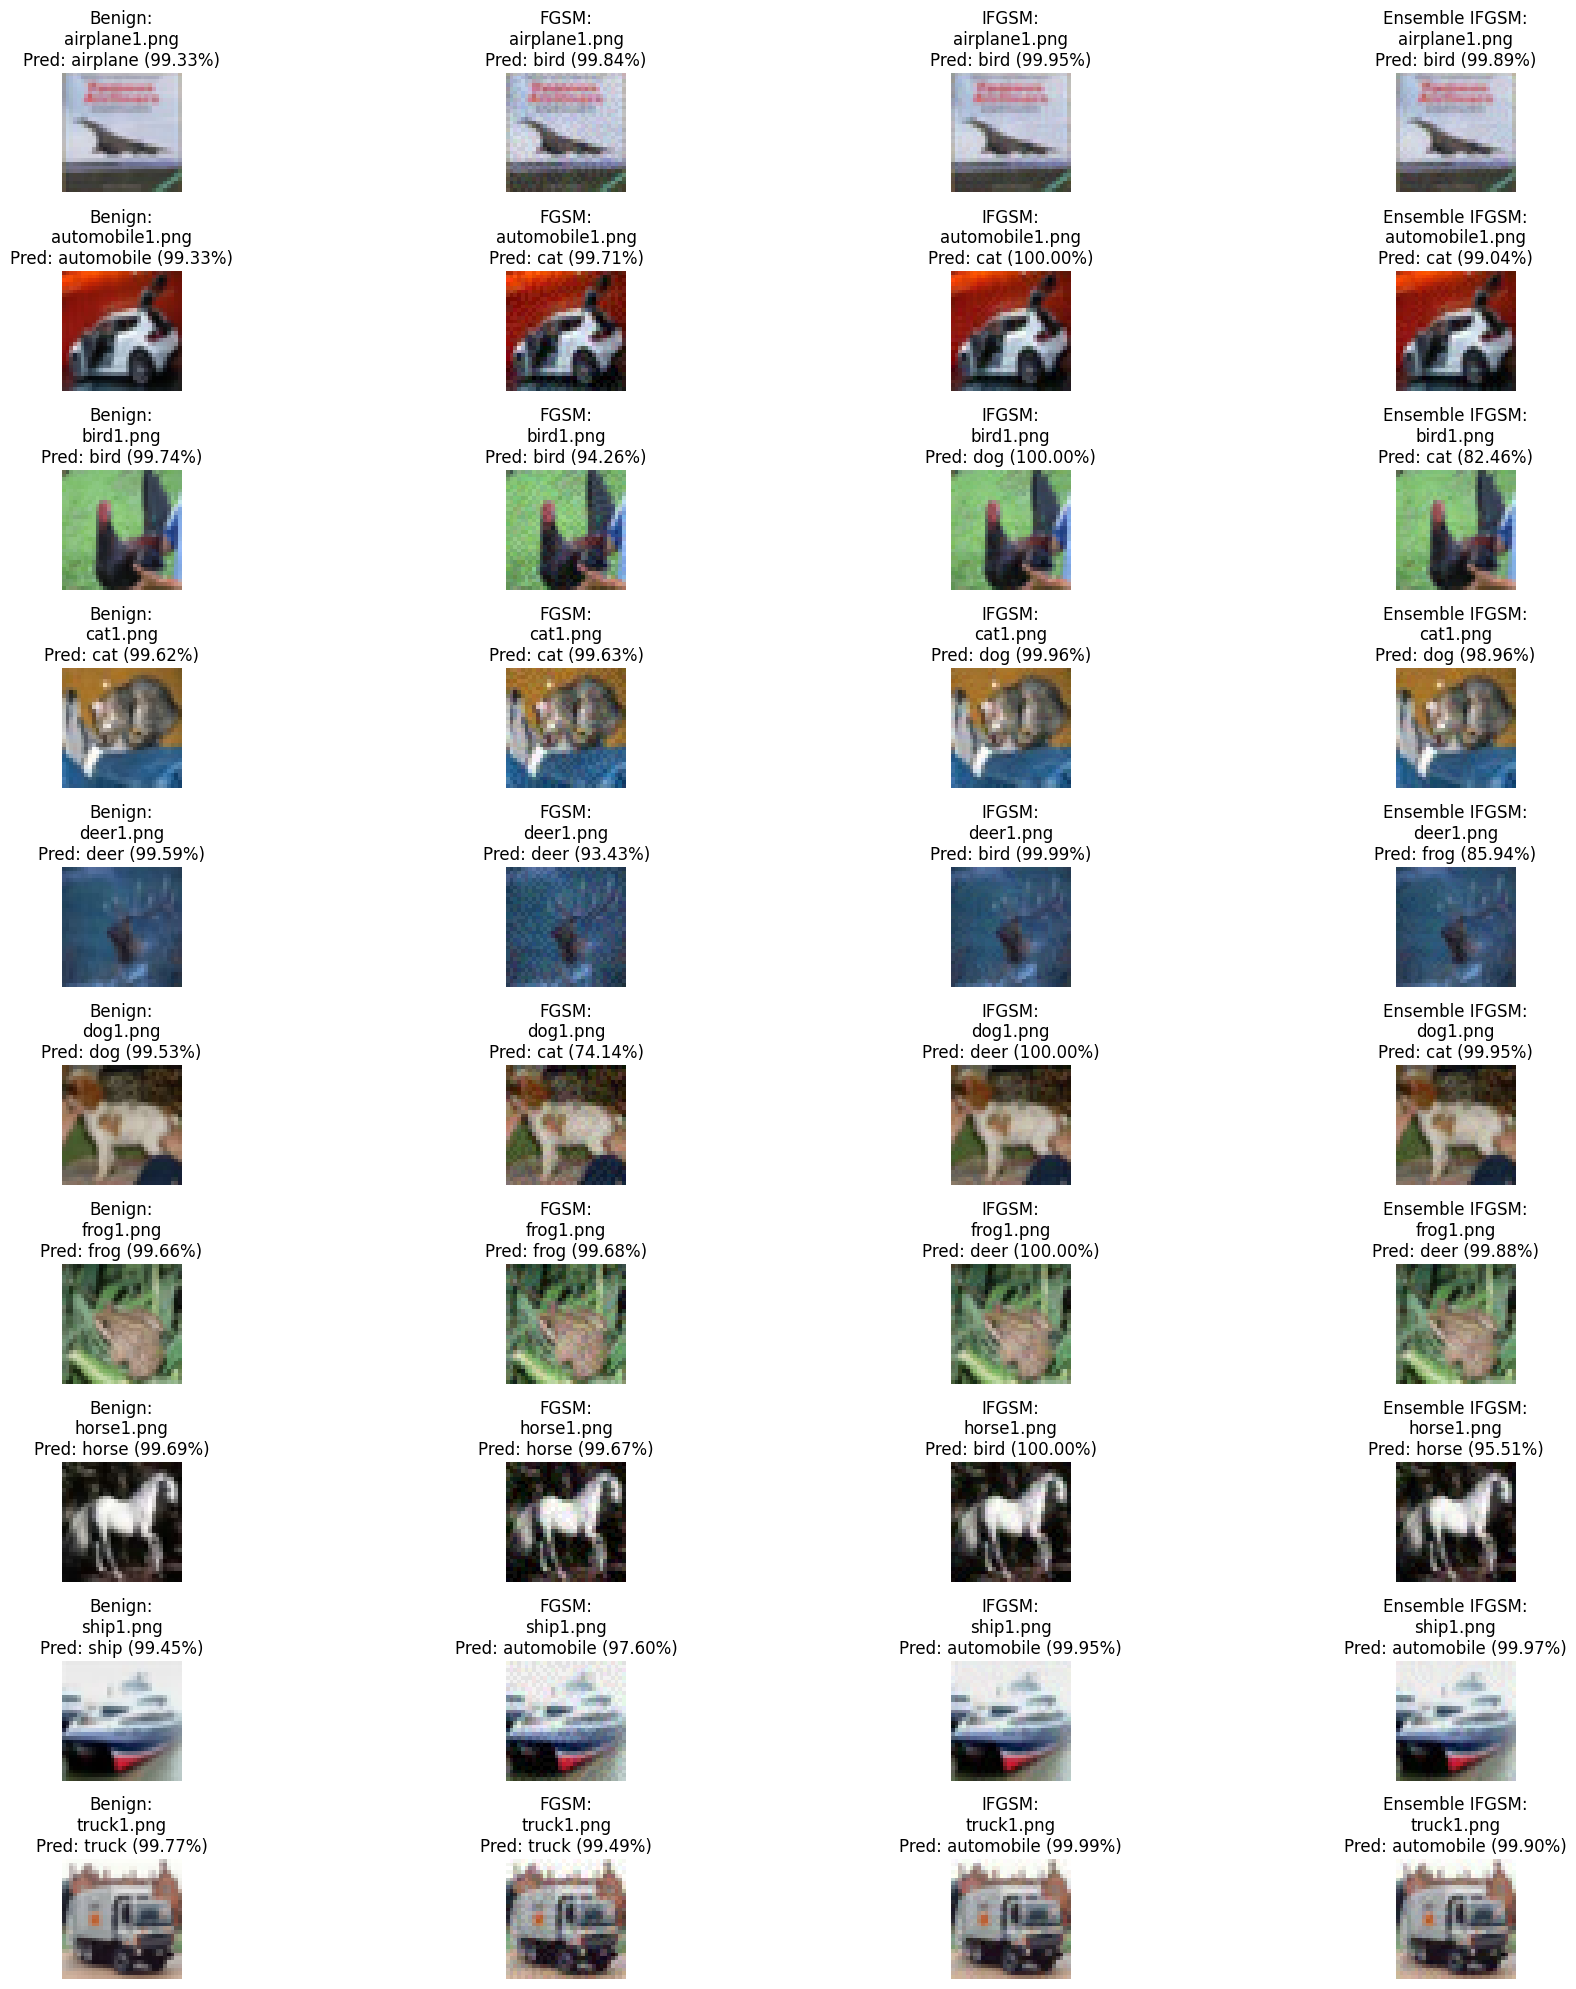

In [ ]:
# Ensemble IFGSM Attack
def ensemble_ifgsm(models, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter):
    x_adv = x.detach().clone()
    x_adv = x_adv.requires_grad_(True)

    for _ in range(num_iter):
        loss_total = 0.0
        for model in models:
            outputs = model(x_adv)
            loss_total += loss_fn(outputs, y)

        loss_total = loss_total / len(models)

        loss_total.backward()
        with torch.no_grad():
            x_adv += alpha * x_adv.grad.sign()
            eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
            x_adv = torch.clamp(x + eta, (0 - mean)/std, (1 - mean)/std).detach_()
            x_adv.requires_grad = True
    return x_adv

def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    adv_examples = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn)
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        adv_ex = ((x_adv * std) + mean).clamp(0, 1)
        adv_ex = (adv_ex * 255).clamp(0, 255)
        adv_ex = adv_ex.detach().cpu().numpy().round().astype(np.uint8)
        adv_ex = adv_ex.transpose((0, 2, 3, 1))
        adv_examples.append(adv_ex)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)


def gen_adv_examples_ensemble(models, loader, attack, loss_fn):
    for model in models:
        model.eval()
    train_acc, train_loss = 0.0, 0.0
    adv_examples = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(models, x, y, loss_fn)

        yp = models[0](x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        adv_ex = ((x_adv * std) + mean).clamp(0, 1)
        adv_ex = (adv_ex * 255).clamp(0, 255)
        adv_ex = adv_ex.detach().cpu().numpy().round().astype(np.uint8)
        adv_ex = adv_ex.transpose((0, 2, 3, 1))
        adv_examples.append(adv_ex)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if not os.path.exists(adv_dir):
        shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example)
        im.save(os.path.join(adv_dir, name))

supported_models = [
    'resnet20_cifar10',
    'resnet56_cifar10',
    'densenet121_cifar10'

]

proxy_models = []
for model_name in supported_models:
    try:
        proxy_model = ptcv_get_model(model_name, pretrained=True).to(device)
        proxy_model.eval()
        proxy_models.append(proxy_model)
        print(f'Successfully loaded {model_name}')
    except ValueError as e:
        print(f'Error loading {model_name}: {e}')

try:
    primary_model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
    primary_model.eval()
    print('Primary model (resnet110_cifar10) loaded successfully.')
except ValueError as e:
    print(f'Error loading primary model: {e}')

loss_fn = nn.CrossEntropyLoss()

benign_acc, benign_loss = epoch_benign(primary_model, adv_loader, loss_fn)
print(f'Benign Accuracy = {benign_acc:.5f}, Benign Loss = {benign_loss:.5f}')



adv_examples_fgsm, fgsm_acc, fgsm_loss = gen_adv_examples(primary_model, adv_loader, fgsm, loss_fn)
print(f'FGSM Attack -> Accuracy: {fgsm_acc:.5f}, Loss: {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples_fgsm, adv_names)



adv_examples_ifgsm, ifgsm_acc, ifgsm_loss = gen_adv_examples(primary_model, adv_loader, ifgsm, loss_fn)
print(f'IFGSM Attack -> Accuracy: {ifgsm_acc:.5f}, Loss: {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples_ifgsm, adv_names)



if len(proxy_models) > 0:
    adv_examples_ensemble, ensemble_acc, ensemble_loss = gen_adv_examples_ensemble(
        proxy_models,
        adv_loader,
        ensemble_ifgsm,
        loss_fn
    )
    print(f'Ensemble IFGSM Attack -> Accuracy: {ensemble_acc:.5f}, Loss: {ensemble_loss:.5f}')

    create_dir(root, 'ensemble_ifgsm', adv_examples_ensemble, adv_names)
else:
    print('No proxy models available for ensemble attack.')



import tarfile

def compress_dir(source_dir, output_filename):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    print(f'Compressed {source_dir} to {output_filename}')


compress_dir('fgsm', 'fgsm.tgz')
compress_dir('ifgsm', 'ifgsm.tgz')
if len(proxy_models) > 0:
    compress_dir('ensemble_ifgsm', 'ensemble_ifgsm.tgz')



classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(20, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'

    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = primary_model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'Benign:\n{cls_name}1.png\nPred: {classes[predict]} ({prob:.2%})')
    plt.axis('off')
    plt.imshow(np.array(im))
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im_fgsm = Image.open(f'./fgsm/{path}')
    logit_fgsm = primary_model(transform(im_fgsm).unsqueeze(0).to(device))[0]
    predict_fgsm = logit_fgsm.argmax(-1).item()
    prob_fgsm = logit_fgsm.softmax(-1)[predict_fgsm].item()
    plt.title(f'FGSM:\n{cls_name}1.png\nPred: {classes[predict_fgsm]} ({prob_fgsm:.2%})')
    plt.axis('off')
    plt.imshow(np.array(im_fgsm))


    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im_ifgsm = Image.open(f'./ifgsm/{path}')
    logit_ifgsm = primary_model(transform(im_ifgsm).unsqueeze(0).to(device))[0]
    predict_ifgsm = logit_ifgsm.argmax(-1).item()
    prob_ifgsm = logit_ifgsm.softmax(-1)[predict_ifgsm].item()
    plt.title(f'IFGSM:\n{cls_name}1.png\nPred: {classes[predict_ifgsm]} ({prob_ifgsm:.2%})')
    plt.axis('off')
    plt.imshow(np.array(im_ifgsm))


    if len(proxy_models) > 0:
        cnt += 1
        plt.subplot(len(classes), 4, cnt)
        im_ensemble = Image.open(f'./ensemble_ifgsm/{path}')
        logit_ensemble = primary_model(transform(im_ensemble).unsqueeze(0).to(device))[0]
        predict_ensemble = logit_ensemble.argmax(-1).item()
        prob_ensemble = logit_ensemble.softmax(-1)[predict_ensemble].item()
        plt.title(f'Ensemble IFGSM:\n{cls_name}1.png\nPred: {classes[predict_ensemble]} ({prob_ensemble:.2%})')
        plt.axis('off')
        plt.imshow(np.array(im_ensemble))
    else:

        cnt += 1
        plt.subplot(len(classes), 4, cnt)
        plt.axis('off')
        plt.title('Ensemble IFGSM:\nNo Models')
        plt.imshow(np.zeros((32,32,3), dtype=np.uint8))

plt.tight_layout()
plt.show()
